# Project: TDS Virtual TA Requirement Checklist
- [X] Scrape "TDS Discourse posts with content from 1 Jan 2025 - 14 Apr 2025."
- [X] Scrape "Course content with content for TDS Jan 2025 as on 15 Apr 2025."


## Session handling
| Step | Description | Screenshot |
| --- | --- | --- |
| 1 | Inorder to update the cookies and user agents, I have used below script. <br> It is important to note that I have acquired the intial cookies together with request headers manually <br> I have stored those informations in the form of dictionaries in the files headers.json and cookies.json before running below script. <br> One more functionality i have added to the script is to rotate User-Agent to avoid any blocking of sessions from the server. <br> since the cookies contains confidential informations, i have added both the file names in `.gitignore`, <br> therefore any subsequesnt running from outside of my enviornment need this files added manually | 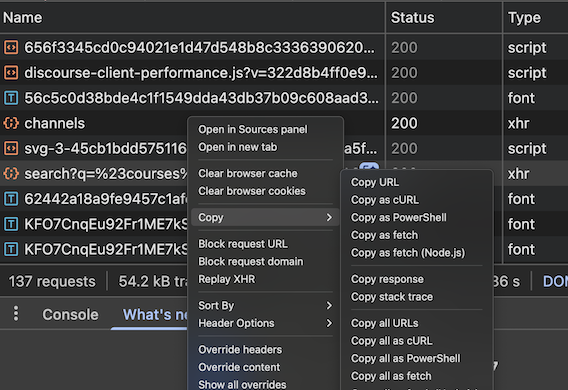 |

In [69]:
import requests
import json
import random
import os

USER_AGENTS = [
    # Popular desktop UAs
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 Chrome/114.0 Safari/537.36",
    "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 Chrome/113.0 Safari/537.36",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 Version/14.0 Safari/605.1.15",
    "Mozilla/5.0 (X11; Linux aarch64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/137.0.0.0 Safari/537.36 CrKey/1.54.250320"
]

def get_discourse_session(url: str = "https://discourse.onlinedegree.iitm.ac.in/search?q=%23courses%3Atds-kb%20after%3A2024-12-31%20before%3A2025-03-15&page=1"):
    session = requests.Session()
    headers = {}
    cookies = {}

    try:
        if os.path.exists("headers.json"):
            with open("headers.json") as f:
                headers = json.load(f)

        if os.path.exists("cookies.json"):
            with open("cookies.json") as f:
                cookies = json.load(f)

        headers["referer"] = url
        # Make request. Disables the certificate verification as i am getting a lot of failures around this
        response = session.get(url, verify=False, headers=headers, cookies=cookies)
        print(response)

        if response.status_code != 200:
            print("Error:", response.status_code)
            return {"error": "Failed to retrieve data"}

        return response.json()
    
    except requests.RequestException as e:
        print("Request error:", e)
        return {"error": str(e)}
    
    except json.JSONDecodeError as e:
        print("Failed to parse JSON file:", e)
        return {"error": "Invalid JSON in headers or cookies"}
    
    except Exception as e:
        print("Unexpected error:", e)
        return {"error": str(e)}

    finally:
        
        # Save cookies and headers
        cookies["_t"] = session.cookies.get("_t")
        if cookies["_t"]:
            with open("cookies.json", "w") as f:
                json.dump(cookies, f)

        headers["user-agent"] = random.choice(USER_AGENTS)
        headers["x-csrf-token"] = response.request.headers.get("x-csrf-token")
        if headers["x-csrf-token"]:
            with open("headers.json", "w") as f:
                json.dump(headers, f)

        session.close()



In [ ]:
# Test the session creation and closure functionality
print(get_discourse_session())
print(get_discourse_session())
print(get_discourse_session())
print(get_discourse_session())

## Scrape Discourse data
| Step | Description | Screenshot |
| --- | --- | --- |
| 1 | As first step i have filtered the Topics/posts as in the attached screenshot | 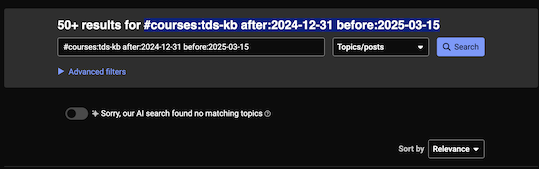 |
| 2 | `95` results as search result. As per the inspections in the Chrome dev tools, <br> found that there are two url navigations triggered as part of the Search result page loading. | https://discourse.onlinedegree.iitm.ac.in/search?q=%23courses%3Atds-kb%20after%3A2024-12-31%20before%3A2025-03-15&page=1 <br> https://discourse.onlinedegree.iitm.ac.in/search?q=%23courses%3Atds-kb%20after%3A2024-12-31%20before%3A2025-03-15&page=2 |
| 3 | Found a json object with this structure.  | 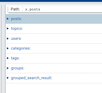 |

In [ ]:
import requests
from urllib.parse import urlencode

baseurl = "https://discourse.onlinedegree.iitm.ac.in/search"
params1 = {
    "q": "#courses:tds-kb after:2024-12-31 before:2025-03-15",
    "page": 1
}
params2 = {
    "q": "#courses:tds-kb after:2024-12-31 before:2025-03-15",
    "page": 2
}

def scrape_data(url, params):
    # Construct the full URL with query parameters
    full_url = f"{url}?{urlencode(params)}"

    return get_discourse_session(full_url)

p1 = scrape_data(baseurl, params1)
p2 = scrape_data(baseurl, params2)

## p1 and p2 have structure similar to below image
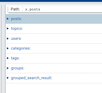

In [78]:
# Script to verify the json structure
import json

def print_json_structure(data, prefix=""):
    if isinstance(data, dict):
        for key, value in data.items():
            new_prefix = f"{prefix}.{key}" if prefix else key
            print(f"{new_prefix} : {type(value).__name__}")
            print_json_structure(value, new_prefix)
    elif isinstance(data, list):
        print(f"{prefix}[] : list of {type(data[0]).__name__}" if data else f"{prefix}[] : list")
        if data:
            print_json_structure(data[0], prefix + "[]")

In [ ]:
# Check structure
print_json_structure(p1)

In [ ]:
# Verify the results
print(p1)
print(p2)

In [74]:
# Verify the count of posts in each page
countp1 = 0
countp2 = 0
for post in p1['posts']:
    countp1 += 1
for post in p2['posts']:
    countp2 += 1

print(f"Page 1 has {countp1} posts.")
print(f"Page 2 has {countp2} posts.")

# Verify the types of the results
print(type(p1))
print(type(p2))

Page 1 has 50 posts.
Page 2 has 45 posts.
<class 'dict'>
<class 'dict'>


## Combine all posts
| Step | Description | Screenshot |
| --- | --- | --- |
| 1 | If we expand `posts` key further, it contains a list of posts with attched key values pairs. | 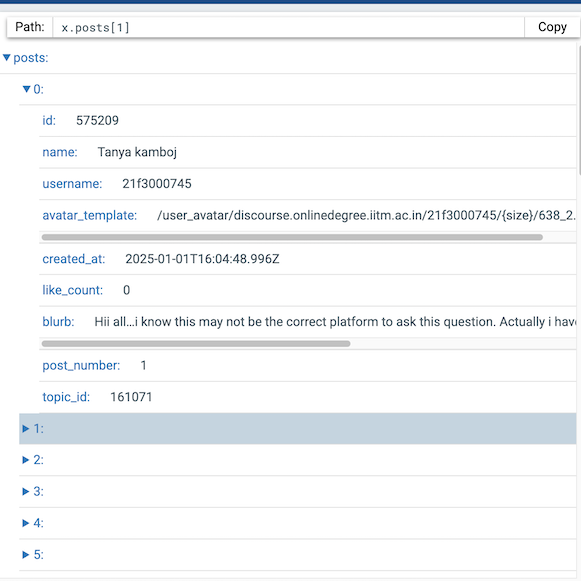 |
| 2 | Each post contains a post id and topic id, which probabably help to formulate the source urls. | Look above |
| 3 | In additin to that we have two seperate list of posts which we need to combine. | |


In [76]:
import json

merged = p1.copy()

for key, val in p2.items():
    if key == 'posts' and isinstance(val, list):
        # concatenate the two lists
        merged['posts'] = p1.get('posts', []) + val
    else:
        # for other keys, p2’s value wins
        merged[key] = val

json_data_str = json.dumps(merged, indent=4)


In [77]:
# Verifying after the merge the count of post is same as the sum of previous two post lists (50 + 45)
countmerged = 0
for post in merged['posts']:
    countmerged += 1

print(f"Merged data has {countmerged} posts.")

Merged data has 95 posts.


In [ ]:
# Verify structure
print_json_structure(merged)

#### Remove unnecessary keys from the data

In [82]:
keys_to_remove = [
    "topics",
    "users",
    "categories",
    "tags",
    "groups",
    "grouped_search_result"
]

json_data = json.loads(json_data_str)
json_data_filtered = {k: v for k, v in json_data.items() if k not in keys_to_remove}

json_data_filtered_json = json.dumps(json_data_filtered, indent=2)

In [83]:
print_json_structure(json_data_filtered)

posts : list
posts[] : list of dict
posts[].id : int
posts[].name : str
posts[].username : str
posts[].avatar_template : str
posts[].created_at : str
posts[].like_count : int
posts[].blurb : str
posts[].post_number : int
posts[].topic_id : int


#### I thought of creating a list of set (topic_id, post_id), individual posts contains too less informations to formulate answers for a query. The answers will be a symantic formulation of whole messages within a post. In such cases it is really hard to point to a single post as refernce url. Rather i choose to use topic URL.


In [88]:
list_topic_id = [entry["topic_id"] for entry in json_data_filtered["posts"]]

In [89]:
print(list_topic_id)

[161071, 163247, 166189, 169029, 169283, 169888, 164277, 168916, 169807, 169369, 168832, 168506, 169393, 169352, 166576, 169247, 99838, 168449, 169045, 168537, 168987, 168901, 168943, 168825, 141413, 168476, 166651, 168515, 168567, 168384, 168458, 168482, 168011, 168310, 168303, 168142, 165959, 168143, 168057, 168017, 167878, 166816, 167679, 167344, 167415, 167471, 167410, 167699, 167172, 164214, 166891, 167072, 166738, 166647, 166634, 166498, 165416, 165433, 161120, 166303, 166357, 166349, 165687, 166100, 165396, 165922, 165830, 165746, 165593, 23335, 163158, 165142, 164869, 164737, 164462, 164460, 164291, 164147, 163765, 164205, 164089, 163381, 163241, 163224, 163147, 161072, 163144, 162425, 161214, 160251, 160773, 161083, 169456, 166866, 166593]


In [90]:
len(list_topic_id)

95

#### Traverse through each topic URL and record those data. Structure of the response json contains this structure.
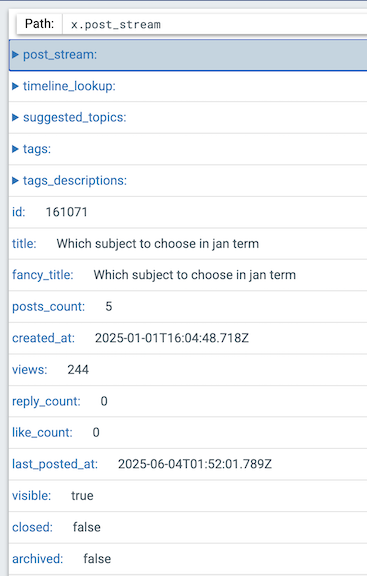

In [92]:
def scrape_topic_data(topic_id):
    full_url = f"https://discourse.onlinedegree.iitm.ac.in/t/{topic_id}.json"

    return get_discourse_session(full_url)


#### Image understanding using gemini models. Need to set either GOOGLE_API_KEY or GEMINI_API_KEY as environemnte variable

In [202]:
from google import genai
from google.genai import types
from requests.exceptions import RequestException
import os

client = genai.Client(api_key=os.environ["GEMINI_API_KEY"])

def understand_image(image_path):
    print("Image:", image_path)
    try:
        image_bytes = requests.get(image_path).content
        content_type = ""
        head = requests.head(image_path, timeout=5)
        content_type = head.headers.get('Content-Type')
        image = types.Part.from_bytes(
            data=image_bytes,mime_type=content_type
        )
        response = client.models.generate_content(
            model="gemini-2.0-flash",
            contents=[image, "What is in this image?"],
        )
        return response.text
    
    except RequestException as e:
        print(f"[Warning] Failed to download image header: {e}")
        return None

Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.


#### Testing topic data scraping

In [ ]:
from bs4 import BeautifulSoup

topic_data = scrape_topic_data(161120)
question = 0
for post in topic_data.get("post_stream", {}).get("posts", []):
    r = post.get('cooked', '<p>No content available<p>')
    soup = BeautifulSoup(r, 'html.parser')

    print(topic_data.get("slug"))
    print(topic_data.get("title"))
    if question == 0:
        print(f"Question: {soup.get_text(separator=' ',strip=True)}\n")
    else:
        print(f"Response {question}: {soup.get_text(separator=' ',strip=True)}\n")
    images = soup.find_all('img')
    if images:
        for img in images:
            if img.get('src'):
                if "slight_smile.png" not in img.get('src'):
                    print(understand_image(img.get('src')))
    question += 1

#### Testing the delay setting while scraping

In [96]:

from datetime import datetime, timedelta
import time

now_local = time.time()
print(now_local)
time.sleep(5)
print(time.time() - now_local)

1750020999.1067069
5.005321025848389


In [97]:
if all(sub not in "https://emoji.discourse-cdn.com/google/clap.png?v=12" for sub in ["slight_smile.png","emoji"]):
    print(1)

In [ ]:
from bs4 import BeautifulSoup
import time

now_local = 5

for topic_id in list_topic_id:
    print(topic_id,"\n")
    try:
        with open(f'discourse/{topic_id}.txt', 'x', encoding='utf-8') as f:
            topic_data = scrape_topic_data(topic_id)
            if "error" not in topic_data:
                print(f"Title: {topic_data.get('title' , ' ')}\n")
                f.write(f"Title: {topic_data.get('title' , ' ')}\n")
                print(f"source_url: https://discourse.onlinedegree.iitm.ac.in/t/{topic_data.get('slug' , '')}/{topic_id}\n\n")
                f.write(f"source_url: https://discourse.onlinedegree.iitm.ac.in/t/{topic_data.get('slug' , '')}/{topic_id}\n\n")
                question = 0
                for post in topic_data.get("post_stream", {}).get("posts", []):
                    r = post.get('cooked', '<p>No content available<p>')
                    soup = BeautifulSoup(r, 'html.parser')
                    if question == 0:
                        f.write(f"Question: {soup.get_text(separator=' ',strip=True)}\n")
                    else:
                        f.write(f"Response {question}: {soup.get_text(separator=' ',strip=True)}\n")
                    
                    f.write("\n")
                    images = soup.find_all('img')

                    if images:
                        for img in images:
                            if img.get('src'):
                                if all(sub not in img.get('src') for sub in ["slight_smile.png","emoji","avatar","favicon","logo"]):
                                    if (time.time() - now_local) < 5:
                                        time.sleep(5)
                                    now_local = time.time()
                                    image_def = understand_image(img.get('src'))
                                    if image_def:
                                        f.write(f"Image explanation: {image_def}\n")
                    question += 1
            else:
                print(f"Failed to retrieve data for topic ID {topic_id}: {topic_data['error']}")
    except FileExistsError:
        print(f"File '{topic_id}.txt' already exists; will not overwrite.") 

In [ ]:
# Ignore below script, it is used to rename files in the discourse directory in certain circumstances earlier.
import os

directory = "discourse/"
for filename in os.listdir(directory):
    if filename.lower().endswith('.txt') and ' ' in filename:
        original_path = os.path.join(directory, filename)
        new_name = filename.split(' ')[0]
        new_path = os.path.join(directory, new_name)
        print(original_path, new_path)

        try:
            os.rename(original_path, new_path)
            print(f"Renamed '{filename}' to '{new_name}'.")
        except OSError as e:
            print(f"Error renaming '{filename}': {e}")
        

In [ ]:
# This script is not required as the source urls and Title update is done in the previous script.
for topic_id in list_topic_id:

    path = f"discourse/{topic_id}.txt"
    topic_data = scrape_topic_data(topic_id)

    if "error" not in topic_data:
        # 1. Read the existing content
        with open(path, 'r', encoding='utf-8') as f:
            old = f.read()

        # 2. Re-open in write mode (this truncates the file) and write header + old
        with open(path, 'w', encoding='utf-8') as f:
            print(f"Title: {topic_data.get('title' , ' ')}\n")
            f.write(f"Title: {topic_data.get('title' , ' ')}\n")
            print(f"source_url: https://discourse.onlinedegree.iitm.ac.in/t/{topic_data.get('slug' , '')}/{topic_id}\n\n")
            f.write(f"source_url: https://discourse.onlinedegree.iitm.ac.in/t/{topic_data.get('slug' , '')}/{topic_id}\n\n")
            f.write(old)


In [99]:

import nltk

nltk.download('punkt', quiet=True)
nltk.download('punkt_tab')

def getchunks(text: str, max_chunk_chars: int = 1000, overlap_chars: int = 200):
    length = len(text)
    # Determine step size, ensure it's positive
    step = max_chunk_chars - overlap_chars if max_chunk_chars > overlap_chars else max_chunk_chars
    chunks = []
    # Slide window across the text
    for start in range(0, length, step):
        end = start + max_chunk_chars
        chunks.append(text[start:end])
        if end >= length:
            break
    return chunks

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/weigfhx/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [104]:

import nltk

nltk.download('punkt', quiet=True)
nltk.download('punkt_tab')

def semantic_split_text(text: str, max_chunk_chars: int = 1000):
    normalized = text.replace('\n\n', ' <NL> ')
    normalized = normalized.replace('\n', ' <NL> ')

    return getchunks(normalized)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/weigfhx/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
with open("discourse/160773.txt", 'r', encoding='utf-8') as file:
    text = file.read()

semantic_split_text(text)

In [106]:
import re

def find_images_from_markdown(markdown_text):
    # Match inline image syntax ![alt](url)
    inline_img_pattern = r'!\[.*?\]\((.*?)\)'
    
    # Match reference-style image labels ![alt][label]
    ref_label_pattern = r'!\[.*?\]\[(.*?)\]'
    
    # Match the actual reference definitions [label]: url
    ref_def_pattern = r'\[(.*?)\]:\s*(\S+)'

    # Find inline image URLs
    inline_imgs = re.findall(inline_img_pattern, markdown_text)

    # Extract reference definitions
    ref_def_dict = dict(re.findall(ref_def_pattern, markdown_text))

    # Find all reference image labels
    ref_labels = re.findall(ref_label_pattern, markdown_text)

    # Resolve labels to actual URLs
    ref_imgs = [ref_def_dict.get(label) for label in ref_labels if label in ref_def_dict]

    # Combine all found image URLs
    all_images = inline_imgs + ref_imgs
    return all_images


In [ ]:
for dirpath, _, filenames in os.walk("tds_backup"):
        for fname in filenames:
            if fname.lower().endswith('.md'):
                path = os.path.join(dirpath, fname)
                with open(path, 'r', encoding='utf-8') as f:
                    text = f.read()

                print(path," = ", find_images_from_markdown(text))

In [123]:
import re

def find_youtube_links(markdown_text):
    # Pattern to match YouTube links (both plain and inside markdown links)
    youtube_pattern = re.compile(
        r'https?://(?:www\.)?(?:youtube\.com/watch\?v=|youtu\.be/)[\w\-]+(?:[&?=\w\-]*)'
    )
    return youtube_pattern.findall(markdown_text)



In [117]:
# Extract video ID from URL
def extract_video_id(url):
    import re
    match = re.search(r"(?:v=|youtu\.be/)([a-zA-Z0-9_-]{11})", url)
    return match.group(1) if match else None

In [137]:
from youtube_transcript_api import YouTubeTranscriptApi

def get_youtube_transcript(video_url):
    # Extract video ID from the URL
    video_id = extract_video_id(video_url)
    try:
        transcript_list = YouTubeTranscriptApi.list_transcripts(video_id)
        transcript = transcript_list.find_transcript(['en'])
        transcript_data = transcript.fetch()
        # full_text = "\n".join([item['text'] for item in transcript_data])
        return transcript_data
    except Exception as e:
        print(f"Error fetching transcript for {video_url}: {e}")
        return []


In [ ]:
t = get_youtube_transcript('https://youtu.be/pqNCD_5r0IU')
print(t)

In [147]:
print(t.snippets[0].text)
print(type(t))

now we are live so we can start decision
<class 'youtube_transcript_api._transcripts.FetchedTranscript'>


In [152]:
yt = []
if t:
    for i in t.snippets:
        yt.append(i.text)

print(" ".join(yt))

In [124]:
full_yt_links = []
for dirpath, _, filenames in os.walk("tds_backup"):
    for fname in filenames:
        if fname.lower().endswith('.md'):
            path = os.path.join(dirpath, fname)
            with open(path, 'r', encoding='utf-8') as f:
                text = f.read()

            full_yt_links.extend(find_youtube_links(text))

In [ ]:
full_yt_links

In [ ]:
from tqdm import tqdm

full_yt_transcripts = []
for video_url in tqdm(full_yt_links):
    t = get_youtube_transcript(video_url)
    yt = []
    if t:
        for i in t.snippets:
            yt.append(i.text)
    full_yt_transcripts.append((video_url, " ".join(yt)))


In [157]:
total_chunks = []
for t in full_yt_transcripts:
    total_chunks.append(t[1])

import tiktoken
total_chunks_string = " ".join(total_chunks)

encoding = tiktoken.encoding_for_model("gpt-4o")
tokens = encoding.encode(total_chunks_string)
print(f"Number of tokens: {len(tokens)}")

Number of tokens: 1135137


In [162]:
def get_no_tokens(text: str):
    encoding = tiktoken.encoding_for_model("gpt-4o")
    tokens = encoding.encode(text)
    return len(tokens)

test_string ="Hello! It seems you haven't provided any text for me to summarize. Could you please share the text you'd like summarized?"
print(f"Number of tokens: {get_no_tokens(test_string)}")

Number of tokens: 24


In [156]:
len(total_chunks)

235

In [158]:
import openai
import httpx

client = openai.OpenAI(http_client=httpx.Client(verify=False))
final_yt_transcripts = []
for t in tqdm(full_yt_transcripts):
    response = client.chat.completions.create(
        model="gpt-4.0-mini",  # or "gpt-4"
        messages=[
            {"role": "developer", "content": "You are a helpful assistant. Summarize the following text without losing any important information."},
            {"role": "user", "content": t[1]},
        ],
        temperature=0.7
    )
    final_yt_transcripts.append((t[0], response.choices[0].message.content))

100%|██████████| 235/235 [25:21<00:00,  6.48s/it]


In [ ]:
final_yt_transcripts

In [164]:
final_yt_transcripts_map = {}
for t in final_yt_transcripts:
    final_yt_transcripts_map[t[0]] = t[1]


In [ ]:
final_yt_transcripts_map

In [175]:
# Replacement function
def replace_with_summary(match):
    full_url = match.group(1)
    summary = final_yt_transcripts_map.get(full_url)

    if summary:
        return f"{full_url}\n<youtube_summary>{summary}</youtube_summary>\n"
    else:
        return full_url

In [ ]:
youtube_pattern = re.compile(r"(https?://(?:www\.)?(?:youtube\.com/watch\?v=|youtu\.be/)([\w-]+))")
with open("tds_backup/data-preparation-in-the-shell.md", "r", encoding="utf-8") as f:
    md_content = f.read()
updated_md = youtube_pattern.sub(replace_with_summary, md_content)

print(md_content)
print(updated_md)

In [ ]:
youtube_pattern = re.compile(r"(https?://(?:www\.)?(?:youtube\.com/watch\?v=|youtu\.be/)([\w-]+))")
for dirpath, _, filenames in os.walk("tds"):
    for fname in filenames:
        if fname.lower().endswith('.md'):
            path = os.path.join(dirpath, fname)
            with open(path, 'r', encoding='utf-8') as f:
                text = f.read()
            links = find_youtube_links(text)
            print(links)

            for link in links:
                if link in final_yt_transcripts_map.keys():
                    if get_no_tokens(final_yt_transcripts_map[link]) > 30:
                        replacement = f"{link}\n<youtube_summary>{final_yt_transcripts_map[link]}</youtube_summary>\n"

                        with open(path, "r", encoding="utf-8") as f:
                            md_content = f.read()

                        updated_md = md_content.replace(link, replacement)
                        with open(path, "w", encoding="utf-8") as f:
                            f.write(updated_md)


In [178]:
print(links)

[]


In [180]:

import nltk
import re

nltk.download('punkt', quiet=True)
nltk.download('punkt_tab')

def semantic_split_markdown(md: str, max_chunk_chars: int = 1000):
    # 1. Remove front matter & comments
    md = re.sub(r'^---.*?---\s*', '', md, flags=re.S)
    md = re.sub(r'<!--.*?-->', '', md, flags=re.S)

    # 2. Inline link & image normalization
    md = re.sub(r'!\[(.*?)\]\((.*?)\)', r'Image: \1 (\2)', md)
    md = re.sub(r'\[(.*?)\]\((.*?)\)', r'\1 (\2)', md)

    # 3. Heading markers
    md = re.sub(r'^(#{1,3})\s*(.+)$', lambda m: f"<H{len(m.group(1))}> {m.group(2)}", md, flags=re.M)

    # 4. Flatten whitespace
    md = md.replace('\n\n', ' <PARA> ')
    md = md.replace('\n', '<NL>')
    md = re.sub(r'\s+', ' ', md)
    
    return getchunks(md.strip(), max_chunk_chars)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/weigfhx/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
with open("tds/cors.md", 'r', encoding='utf-8') as file:
    text = file.read()

semantic_split_markdown(text)
# for i in semantic_split_markdown(text):
#     print(i)

In [ ]:
for dirpath, _, filenames in os.walk('tds'):
    print(dirpath,filenames)

In [ ]:
from google import genai
from google.genai import types
import certifi
from requests.exceptions import RequestException
from openai import OpenAI
from google.auth.transport.requests import Request

def get_embedding(chunk: str, model: str = "text-embedding-3-small"):
    client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

    response = client.embeddings.create(
        input=chunk,
        model=model
    )

    return response.data[0].embedding

In [ ]:
# with open("tds/cors.md", 'r', encoding='utf-8') as file:
    # text = file.read()

# print(get_embedding(semantic_split_markdown(text)))
print(get_embedding('abc'))
# import ssl
# print(ssl.get_default_verify_paths())


In [ ]:
topic_data = scrape_topic_data(topic_id)
if "error" not in topic_data:
    print(f"Title: {topic_data.get('title' , ' ')}\n")
    f.write(f"Title: {topic_data.get('title' , ' ')}\n")
    print(f"source_url: https://discourse.onlinedegree.iitm.ac.in/t/{topic_data.get('slug' , '')}/{topic_id}\n\n")
    f.write(f"source_url: https://discourse.onlinedegree.iitm.ac.in/t/{topic_data.get('slug' , '')}/{topic_id}\n\n")

In [185]:

import time

def process_files(root_dir: str, max_chunk_chars: int = 1000):
    now_local = 5
    all_chunks = []
    all_embeddings = []
    all_source_urls = []

    for dirpath, _, filenames in os.walk(root_dir):
        for fname in filenames:
            path = os.path.join(dirpath, fname)
            if fname.lower().endswith('.txt') or fname.lower().endswith('.md'):
                print("Procesing: ", path)
                with open(path, 'r', encoding='utf-8') as file:
                    text = file.read()
                
                url = ""
                if fname.lower().endswith('.txt'):
                    print("Trigger Text splitting")
                    chunks = semantic_split_text(text, max_chunk_chars)
                    topic_id = fname.removesuffix('.txt')
                    topic_data = scrape_topic_data(topic_id)
                    topic_slug = topic_data.get('slug', '')
                    url = f"https://discourse.onlinedegree.iitm.ac.in/t/{topic_slug}/{topic_id}"
                if fname.lower().endswith('.md'):
                    print("Trigger Markdown splitting")
                    chunks = semantic_split_markdown(text, max_chunk_chars)
                    topic_id = fname.removesuffix('.md')
                    url = f"https://tds.s-anand.net/#/{topic_id}"

                print(f"\nFile: {path}\nTotal chunks: {len(chunks)}")
                for i, chunk in enumerate(chunks[:3], 1):
                    print(f"  Chunk {i} preview: {repr(chunk[:80])}...")
                
                for chunk in chunks:
                    all_chunks.append(chunk)
                    if (time.time() - now_local) < 5:
                        time.sleep(5)
                    now_local = time.time()
                    all_embeddings.append(get_embedding(chunk))
                    all_source_urls.append(url)
            else:
                print("Skipping: ", path)

    return all_chunks, all_embeddings, all_source_urls

In [15]:
def test_process_files(root_dir: str, max_chunk_chars: int = 1000):
    for dirpath, _, filenames in os.walk(root_dir):
        for fname in filenames:
            path = os.path.join(dirpath, fname)
            print(path)
            print(fname)
            print(fname.lower().endswith('.txt'))
            print(fname.lower().endswith('.md'))
            # if fname.lower().endswith('.txt'):
            #     chunks = semantic_split_text(path, max_chunk_chars)
            # elif fname.lower().endswith('.md'):
            #     chunks = semantic_split_markdown(path, max_chunk_chars)
            # print(f"\nFile: {path}\nTotal chunks: {len(chunks)}")
            # for i, chunk in enumerate(chunks[:3], 1):
            #     print(f"  Chunk {i} preview: {repr(chunk[:80])}...")

In [ ]:
tds_chunks,tds_embeddings,tds_sourse_urls = process_files("tds")
discourse_chunks,discourse_embeddings,discourse_sourse_urls = process_files("discourse")

In [ ]:
print(discourse_sourse_urls)

In [ ]:
print(tds_sourse_urls)

In [189]:
print(len(tds_chunks))
print(len(discourse_chunks))
print(len(tds_embeddings))
print(len(discourse_embeddings))
print(len(tds_sourse_urls))
print(len(discourse_sourse_urls))

1529
442
1529
442
1529
442


In [190]:
list1 = ["a",3,[1,2,3]]
list2 = ["b",4,[4,5,6]]
list3 = list1 + list2
print(list3)

['a', 3, [1, 2, 3], 'b', 4, [4, 5, 6]]


In [192]:
final_chunks = tds_chunks + discourse_chunks
final_embeddings = tds_embeddings + discourse_embeddings
final_source_urls = tds_sourse_urls + discourse_sourse_urls


In [193]:
print(len(tds_chunks))
print(len(discourse_chunks))
print(len(tds_embeddings))
print(len(discourse_embeddings))
print(len(tds_sourse_urls))
print(len(discourse_sourse_urls))
print(len(final_chunks))
print(len(final_embeddings))
print(len(final_source_urls))

1529
442
1529
442
1529
442
1971
1971
1971


In [ ]:
print(final_chunks[0])
print(final_embeddings[0])
print(final_source_urls[0])

In [ ]:
print(final_chunks[2])

In [195]:
import numpy as np

np.savez("embeddings.npz", chunks=final_chunks, embeddings=final_embeddings, source_urls=final_source_urls)

In [198]:
ranked_text = """To address the user question "How to convert log files to CSV?", the snippets should be ranked based on their relevance to the process of converting log files to CSV format. Here is the reranked order:

1. Snippet 5: This snippet directly addresses converting logs to CSV using `sed` to replace characters, which is highly relevant to the user's question about converting log files to CSV.

2. Snippet 8: This snippet provides a specific command using `sed` to convert log files to CSV format, which is directly relevant to the user's question.

3. Snippet 2: This snippet discusses using `sed` to convert log files into a CSV-like format, which is relevant to the user's question about converting log files to CSV.

4. Snippet 1: This snippet mentions downloading a `log.csv` file and discusses issues with CSV formatting, which is somewhat relevant to the user's question.

5. Snippet 3: This snippet includes code for parsing log files, which could be relevant for understanding how to extract data from logs before converting to CSV.

6. Snippet 9: This snippet mentions using shell commands like `sed` and `awk` for text processing, which could be relevant for converting log files to CSV.

7. Snippet 4: This snippet discusses converting data to various formats, including CSV, but is less specific about log files.

8. Snippet 6: This snippet is about downloading log files, which is not directly relevant to converting them to CSV.

9. Snippet 10: This snippet discusses handling corrupted CSV files and creating large CSV datasets, which is not directly relevant to converting log files to CSV.

10. Snippet 7: This snippet is about converting JSON to CSV and text manipulation in Excel, which is not directly relevant to converting log files to CSV.
"""
print(re.findall(r"(?:\*\*|^|\n)?(?:\d+\.\s*)?Snippet\s+(\d+)", ranked_text, flags=re.IGNORECASE))

['5', '8', '2', '1', '3', '9', '4', '6', '10', '7']


In [ ]:
print(final_chunks[1230])
print(final_chunks[1228])